In [1]:
#general package
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy import stats

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

import random
import tensorflow as tf 


In [2]:
df_bat = pd.read_csv('/Users/quinne/Desktop/all_code/dissertation_dataset/halftime_encode_python.csv')
df_bat

,Result,match_number,team_code,opponent_code,gender,season,team_score,team_wickets,winner_code,toss_winner_code,home_advantage,venue_city_code,choose_to_bat,avg_score,avg_win_rate,avg_wickets_out,last_match_result
0,1,5,4,1,0,2021,132,7,4,1,0,1,0,139.000000,1.000000,5.000000,1
1,1,6,0,2,0,2021,113,9,0,0,0,2,1,128.000000,0.000000,6.000000,0
2,1,7,3,6,0,2021,149,7,3,3,0,6,1,131.000000,1.000000,4.000000,1
3,0,8,7,5,0,2021,110,7,5,5,1,5,0,130.000000,0.000000,8.000000,0
4,1,10,6,1,0,2021,151,4,6,6,0,1,1,116.000000,0.000000,7.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,30,1,0,1,2022,139,6,0,0,1,0,0,140.642857,0.428571,6.571429,0
111,1,31,3,5,1,2022,135,8,3,5,1,5,0,152.714286,0.428571,6.000000,1
112,0,32,4,2,1,2022,143,9,2,4,0,2,1,145.500000,0.571429,5.785714,1
113,0,40,1,2,1,2022,150,7,2,1,0,2,1,140.533333,0.400000,6.533333,0


In [3]:
df_bat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Result             115 non-null    int64  
 1   match_number       115 non-null    int64  
 2   team_code          115 non-null    int64  
 3   opponent_code      115 non-null    int64  
 4   gender             115 non-null    int64  
 5   season             115 non-null    int64  
 6   team_score         115 non-null    int64  
 7   team_wickets       115 non-null    int64  
 8   winner_code        115 non-null    int64  
 9   toss_winner_code   115 non-null    int64  
 10  home_advantage     115 non-null    int64  
 11  venue_city_code    115 non-null    int64  
 12  choose_to_bat      115 non-null    int64  
 13  avg_score          115 non-null    float64
 14  avg_win_rate       115 non-null    float64
 15  avg_wickets_out    115 non-null    float64
 16  last_match_result  115 non

In [4]:
print(df_bat.shape)

(115, 17)


In [5]:
columns_to_keep = ['Result', "match_number", "team_code", "opponent_code", 
                   "gender", 'season', 'home_advantage', 'venue_city_code',
                   'avg_score', 'avg_win_rate', 'avg_wickets_out', 'last_match_result']
df = df_bat[columns_to_keep]

In [6]:
print(df.shape)

(115, 12)


In [7]:
X = df.drop("Result", axis=1)
y = df['Result']

In [8]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [9]:
# Set random seeds
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

### KNN (K-Nearest Neighbors)

In [10]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding the optimal parameters for KNN
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.arange(1, 51),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_gscv = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
knn_gscv.fit(X_scaled, y)

print("Best parameters for KNN:", knn_gscv.best_params_)

Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}


In [11]:
#Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}

knn = KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='uniform')
y_prob_knn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    knn.fit(X_train, y_train)
    y_prob_knn[test_idx] = knn.predict_proba(X_test)[:, 1]

y_pred_knn = (y_prob_knn > 0.5).astype(int)

print("Predicted Probabilities for KNN:")
print(y_prob_knn)

Predicted Probabilities for KNN:
[0.5 0.5 0.7 0.2 0.6 0.3 0.2 0.6 0.4 0.1 0.3 0.6 0.2 0.9 0.6 0.1 0.4 0.5
 0.8 0.4 0.3 0.2 0.4 0.7 0.1 0.4 0.3 0.5 0.6 0.5 0.3 0.3 0.2 0.5 0.4 0.5
 0.4 0.3 0.5 0.5 0.5 0.4 0.7 0.5 0.5 0.1 0.3 0.4 0.5 0.2 0.3 0.5 0.4 0.3
 0.3 0.4 0.4 0.5 0.2 0.5 0.5 0.7 0.3 0.6 0.7 0.5 0.3 0.5 0.4 0.5 0.6 0.4
 0.3 0.4 0.5 0.4 0.6 0.5 0.3 0.5 0.4 0.4 0.6 0.5 0.6 0.5 0.5 0.7 0.5 0.8
 0.4 0.5 0.6 0.7 0.5 0.5 0.6 0.4 0.4 0.4 0.6 0.5 0.6 0.5 0.6 0.2 0.4 0.7
 0.4 0.7 0.3 0.4 0.4 0.5 0.4]


In [12]:
y_pred_knn

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0])

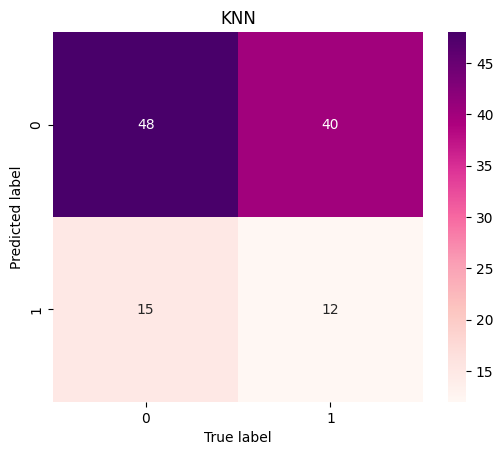

Accuracy:	0.521739
F1-score:	0.469780
Precision:	0.494949
Recall:		0.496337

Classification performance:
              precision    recall  f1-score   support

           0       0.55      0.76      0.64        63
           1       0.44      0.23      0.30        52

    accuracy                           0.52       115
   macro avg       0.49      0.50      0.47       115
weighted avg       0.50      0.52      0.49       115



In [13]:
# Evaluation for KNN
mat_knn = confusion_matrix(y, y_pred_knn)
sns.heatmap(mat_knn.T, square=True, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("KNN")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_knn))
print("F1-score:\t%f" % f1_score(y, y_pred_knn, average='macro'))
print("Precision:\t%f" % precision_score(y, y_pred_knn, average='macro'))
print("Recall:\t\t%f" % recall_score(y, y_pred_knn, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_knn))

### SVM (Support Vector Machine) 

In [14]:
#Finding the optimal parameters for SVM
svm = SVC(probability=True)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']}

svm_gscv = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
svm_gscv.fit(X_scaled, y)

print("Best parameters for SVM:", svm_gscv.best_params_)

Best parameters for SVM: {'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


In [15]:
#Best parameters for SVM: {'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}

# svm = SVC(kernel='linear', probability=True)
svm = SVC(C=1000, gamma='scale', kernel='linear', probability=True)
y_prob_svm = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    svm.fit(X_train, y_train)
    y_prob_svm[test_idx] = svm.predict_proba(X_test)[:, 1]

y_pred_svm = (y_prob_svm > 0.5).astype(int)
print("\nPredicted Probabilities for SVM:")
print(y_prob_svm)


Predicted Probabilities for SVM:
[0.44670089 0.48080693 0.48439917 0.43319145 0.38236457 0.42632282
 0.45264522 0.44309299 0.40493585 0.45544217 0.44703636 0.40069474
 0.44441899 0.5606926  0.45136959 0.40945237 0.34715819 0.54900783
 0.49108164 0.46440752 0.41184173 0.43897782 0.42510332 0.53478455
 0.4400003  0.41830396 0.44172505 0.44312807 0.40822861 0.46387802
 0.43822479 0.43802843 0.31902581 0.474781   0.38699548 0.48304727
 0.36253236 0.44648027 0.44360682 0.44237877 0.47104668 0.45240733
 0.46155075 0.45679917 0.42537058 0.39603884 0.44479248 0.45238036
 0.44116608 0.44364709 0.43588796 0.47424993 0.40102081 0.43490208
 0.43049624 0.47933146 0.48108833 0.44379442 0.44859367 0.47712825
 0.48824125 0.45647297 0.4867557  0.43304209 0.50991853 0.46646741
 0.41722016 0.5        0.47616438 0.47131069 0.43717883 0.43758613
 0.40528128 0.51338462 0.53942656 0.441766   0.45867496 0.47199944
 0.46006419 0.45808106 0.44935959 0.41886749 0.43637057 0.4733532
 0.49254061 0.42356916 0.4806

In [16]:
y_pred_svm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

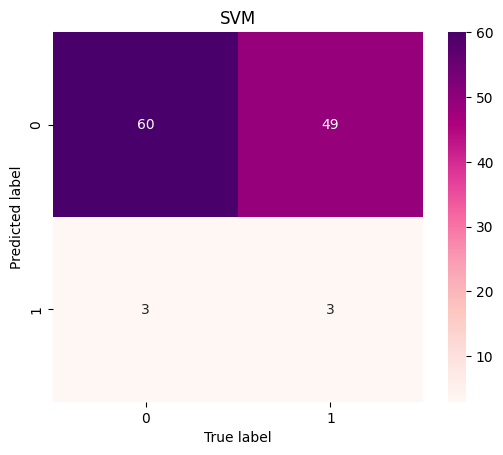

Accuracy:	0.547826
F1-score:	0.400561
Precision:	0.525229
Recall:		0.505037

Classification performance:
              precision    recall  f1-score   support

           0       0.55      0.95      0.70        63
           1       0.50      0.06      0.10        52

    accuracy                           0.55       115
   macro avg       0.53      0.51      0.40       115
weighted avg       0.53      0.55      0.43       115



In [17]:
mat_svm = confusion_matrix(y, y_pred_svm)
sns.heatmap(mat_svm.T, square=True, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_svm))
print("F1-score:\t%f" % f1_score(y, y_pred_svm, average='macro'))
print("Precision:\t%f" % precision_score(y, y_pred_svm, average='macro'))
print("Recall:\t\t%f" % recall_score(y, y_pred_svm, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_svm))

### Deep Netural Networks

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
def create_model(dropout_rate=0.0, activation='relu'):
    model = Sequential()
    model.add(Dense(16, input_dim=11, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20, 30, 40],
    'epochs': [10, 50, 100],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'activation': ['relu', 'tanh']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X_scaled, y)

print("Best parameters found: ", grid_result.best_params_)
print('Best score', grid_result.best_score_)

/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_49168/4101032449.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


2023-09-28 10:03:57.939461: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 10:03:57.973493: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 10:03:57.987197: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 10:03:57.990243: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 10:03:57.999138: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 10:03:58.022424: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 10:03:58.031490: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 10:03:58.082825: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 10:07:48.601476: W tensorflow

Best parameters found:  {'activation': 'tanh', 'batch_size': 40, 'dropout_rate': 0.1, 'epochs': 10}
Best score 0.6484848469495773


In [21]:
#Best parameters found:  {'activation': 'tanh', 'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 100}
#Best score 0.6022727280855179

# Define the model with the optimal parameters
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=11, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

y_prob_dnn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = create_model()
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
    y_prob_dnn[test_idx] = model.predict(X_test).flatten()

y_pred_dnn = (y_prob_dnn > 0.5).astype(int)

print("DNN Model")
print("Predicted Probabilities:")
print(y_prob_dnn) 

1/1 [==============================] - 0s 25ms/step
DNN Model
Predicted Probabilities:
[0.42783809 0.6778776  0.78801483 0.10594705 0.34784281 0.20752203
 0.25142747 0.76760411 0.59291995 0.22508584 0.2746937  0.35157236
 0.20049822 0.81679523 0.61067539 0.14339127 0.17924632 0.63736582
 0.95632011 0.70338267 0.48539221 0.36544129 0.13429494 0.87218463
 0.17129792 0.50909758 0.07454517 0.17780392 0.2643134  0.30014974
 0.58685911 0.32538998 0.07763923 0.62021542 0.07877334 0.60173237
 0.53614342 0.31055734 0.47125563 0.55829269 0.59878308 0.25489005
 0.54690927 0.67252779 0.25641191 0.16384624 0.21675421 0.2404419
 0.54589552 0.07503673 0.19563848 0.59082878 0.11144892 0.14416261
 0.12639803 0.52487528 0.56397039 0.47291142 0.39261737 0.40168563
 0.50327367 0.81047255 0.76472861 0.41407076 0.48950875 0.52413827
 0.28247595 0.50091428 0.6678499  0.72458923 0.48787594 0.27754495
 0.21210399 0.6495266  0.65208608 0.30763569 0.42892915 0.72821635
 0.27475184 0.72160828 0.70110458 0.3238040

In [22]:
y_pred_dnn

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0])

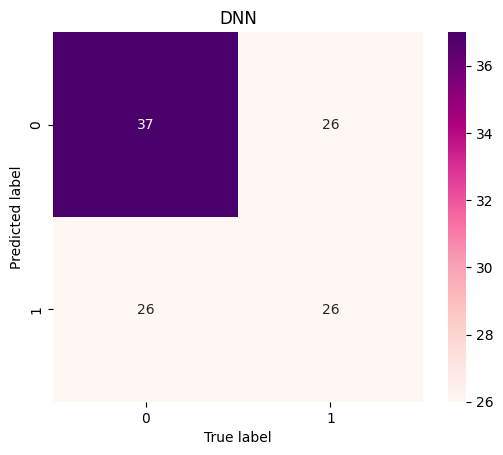

Accuracy:	0.547826
F1-score:	0.500000
Precision:	0.500000
Recall:		0.500000

Classification performance:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        63
           1       0.50      0.50      0.50        52

    accuracy                           0.55       115
   macro avg       0.54      0.54      0.54       115
weighted avg       0.55      0.55      0.55       115



In [23]:
mat_dnn = confusion_matrix(y, y_pred_dnn)
sns.heatmap(mat_dnn.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("DNN")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_dnn))
print("F1-score:\t%f" % f1_score(y, y_pred_dnn))
print("Precision:\t%f" % precision_score(y, y_pred_dnn))
print("Recall:\t\t%f" % recall_score(y, y_pred_dnn))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_dnn))

### Integrated Models

### XGBoost（Extreme Gradient Boosting）

In [24]:
import xgboost as xgb

In [25]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X, y)

print("Best parameters for XGBoost: ", grid_search.best_params_)

Best parameters for XGBoost:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}


In [26]:
#Best parameters for XGBoost:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}

xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.9, 
    learning_rate=0.1, 
    max_depth=7, 
    n_estimators=500, 
    subsample=0.7,
    use_label_encoder=False
)

y_prob_xgb = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_model.fit(X_train, y_train)
    y_prob_xgb[test_idx] = xgb_model.predict_proba(X_test)[:, 1]

y_pred_xgb = (y_prob_xgb > 0.5).astype(int)

print("\nPredicted Probabilities for XGBoost:")
print(y_prob_xgb)

/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Predicted Probabilities for XGBoost:
[0.9113043  0.9959842  0.91978276 0.28968361 0.35409638 0.01283397
 0.15150708 0.05639541 0.94458073 0.16305727 0.02597693 0.02691187
 0.08442254 0.75941902 0.03914353 0.06646032 0.10853269 0.9909752
 0.98267502 0.90153688 0.01033479 0.00144019 0.04755609 0.52820539
 0.13906693 0.24220245 0.37389433 0.08736603 0.22018874 0.58416826
 0.07046657 0.09912316 0.00813416 0.84126133 0.0158952  0.48588607
 0.81343836 0.06485264 0.94100416 0.02418549 0.18227127 0.07036322
 0.93836904 0.99571854 0.00548885 0.08118413 0.32153362 0.24564432
 0.06310773 0.00507469 0.39936602 0.15304701 0.19440822 0.41769597
 0.02686487 0.90269536 0.14639568 0.28707707 0.00456495 0.68693066
 0.82390743 0.43291453 0.58942497 0.48311329 0.7396515  0.04211948
 0.1665574  0.80980623 0.89834189 0.27003676 0.91332024 0.00544643
 0.00752516 0.54873139 0.87709796 0.04681002 0.02046329 0.91806513
 0.02186144 0.91676813 0.98522514 0.95572746 0.0439298  0.95810455
 0.98518282 0.08727308 0.

In [27]:
y_pred_xgb

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0])

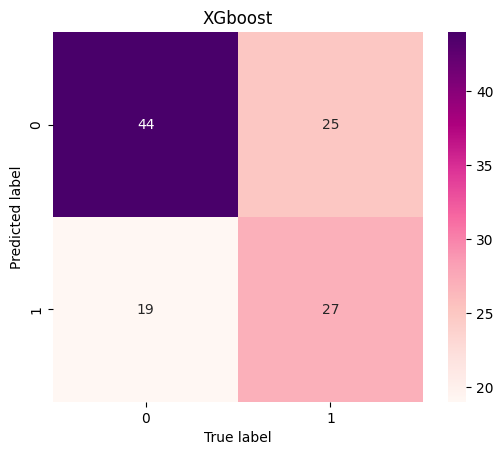

Accuracy:	0.617391
F1-score:	0.551020
Precision:	0.586957
Recall:		0.519231

Classification performance:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        63
           1       0.59      0.52      0.55        52

    accuracy                           0.62       115
   macro avg       0.61      0.61      0.61       115
weighted avg       0.61      0.62      0.61       115



In [28]:
mat_xgb = confusion_matrix(y, y_pred_xgb)
sns.heatmap(mat_xgb.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("XGboost")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_xgb))
print("F1-score:\t%f" % f1_score(y, y_pred_xgb))
print("Precision:\t%f" % precision_score(y, y_pred_xgb))
print("Recall:\t\t%f" % recall_score(y, y_pred_xgb))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_xgb))

### CatBoost 

CatBoost's main advantage: It uses a special algorithm to encode classification features that often works better than traditional One-Hot Encoding or Label Encoding. Because it is not necessary to use the encoded dataset for training catboost, the original dataset can be used.

In [29]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb

In [31]:
df_bat= pd.read_csv('/Users/quinne/Desktop/all_code/dissertation_dataset/halftime_dataframe_R.csv')
df_bat

,Result,match_number,team,opponent,gender,season,team_score,team_wickets,winner,toss_winner,home_advantage,venue_city,choose_to_bat,avg_score,avg_win_rate,avg_wickets_out,last_match_result
0,win,5,Oval Invincibles,London Spirit,female,2021,132,7,Oval Invincibles,London Spirit,no,"Lord's, London London",no,139.000000,1.000000,5.000000,win
1,win,6,Birmingham Phoenix,Manchester Originals,female,2021,113,9,Birmingham Phoenix,Birmingham Phoenix,no,"Old Trafford, Manchester Manchester",yes,128.000000,0.000000,6.000000,lose
2,win,7,Northern Superchargers,Trent Rockets,female,2021,149,7,Northern Superchargers,Northern Superchargers,no,"Trent Bridge, Nottingham Nottingham",yes,131.000000,1.000000,4.000000,win
3,lose,8,Welsh Fire,Southern Brave,female,2021,110,7,Southern Brave,Southern Brave,yes,"Sophia Gardens, Cardiff Cardiff",no,130.000000,0.000000,8.000000,lose
4,win,10,Trent Rockets,London Spirit,female,2021,151,4,Trent Rockets,Trent Rockets,no,"Lord's, London London",yes,116.000000,0.000000,7.000000,lose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,lose,30,London Spirit,Birmingham Phoenix,male,2022,139,6,Birmingham Phoenix,Birmingham Phoenix,yes,"Lord's, London London",no,140.642857,0.428571,6.571429,lose
111,win,31,Northern Superchargers,Southern Brave,male,2022,135,8,Northern Superchargers,Southern Brave,yes,"Headingley, Leeds Leeds",no,152.714286,0.428571,6.000000,win
112,lose,32,Oval Invincibles,Manchester Originals,male,2022,143,9,Manchester Originals,Oval Invincibles,no,"Old Trafford, Manchester Manchester",yes,145.500000,0.571429,5.785714,win
113,lose,40,London Spirit,Manchester Originals,male,2022,150,7,Manchester Originals,London Spirit,no,"The Rose Bowl, Southampton Southampton",yes,140.533333,0.400000,6.533333,lose


In [32]:
df_bat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Result             115 non-null    object 
 1   match_number       115 non-null    int64  
 2   team               115 non-null    object 
 3   opponent           115 non-null    object 
 4   gender             115 non-null    object 
 5   season             115 non-null    int64  
 6   team_score         115 non-null    int64  
 7   team_wickets       115 non-null    int64  
 8   winner             115 non-null    object 
 9   toss_winner        115 non-null    object 
 10  home_advantage     115 non-null    object 
 11  venue_city         115 non-null    object 
 12  choose_to_bat      115 non-null    object 
 13  avg_score          115 non-null    float64
 14  avg_win_rate       115 non-null    float64
 15  avg_wickets_out    115 non-null    float64
 16  last_match_result  115 non

In [33]:
columns_to_keep = ['Result', "match_number", "team", "opponent", 
                   "gender", 'season', 'home_advantage', 'venue_city',
                   'avg_score', 'avg_win_rate', 'avg_wickets_out', 'last_match_result']
df = df_bat[columns_to_keep]

In [34]:
print(df.shape)

(115, 12)


In [35]:
# Transforming the 'Result' column to binary format
df['Result'] = df['Result'].apply(lambda x: 1 if x == 'win' else 0)

/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_49168/3400818731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Result'] = df['Result'].apply(lambda x: 1 if x == 'win' else 0)


In [36]:
# Splitting the data into X (features) and y (target)
X = df.drop(columns=['Result'])
y = df['Result']

# List of categorical features
cat_features = [
    'team', 'opponent', 'gender', 'home_advantage', 'venue_city', 'last_match_result'
]

In [37]:
# Initialize a base model
model = CatBoostClassifier(cat_features=cat_features, verbose=0)

# Parameter grid
grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 500, 1000],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5]
}

# Grid search
grid_search_result = model.grid_search(grid, 
                                       X=Pool(X, label=y, cat_features=cat_features), 
                                       cv=10,  
                                       plot=False)

# Best parameters from grid search
best_params = grid_search_result['params']



bestTest = 0.6930869783
bestIteration = 2

0:	loss: 0.6930870	best: 0.6930870 (0)	total: 186ms	remaining: 14.8s

bestTest = 0.688026097
bestIteration = 21

1:	loss: 0.6880261	best: 0.6880261 (1)	total: 305ms	remaining: 12s

bestTest = 0.6915828762
bestIteration = 2

2:	loss: 0.6915829	best: 0.6880261 (1)	total: 393ms	remaining: 10.2s

bestTest = 0.6932450779
bestIteration = 2

3:	loss: 0.6932451	best: 0.6880261 (1)	total: 500ms	remaining: 9.63s

bestTest = 0.6940503282
bestIteration = 2

4:	loss: 0.6940503	best: 0.6880261 (1)	total: 604ms	remaining: 9.18s

bestTest = 0.6939549389
bestIteration = 1

5:	loss: 0.6939549	best: 0.6880261 (1)	total: 717ms	remaining: 8.96s

bestTest = 0.6931860882
bestIteration = 2

6:	loss: 0.6931861	best: 0.6880261 (1)	total: 798ms	remaining: 8.44s

bestTest = 0.6937300813
bestIteration = 2

7:	loss: 0.6937301	best: 0.6880261 (1)	total: 941ms	remaining: 8.59s

bestTest = 0.6952326105
bestIteration = 56

8:	loss: 0.6952326	best: 0.6880261 (1)	total: 1.05s	r

In [38]:
print("Best parameters for CatBoost: ", best_params)

Best parameters for CatBoost:  {'depth': 5, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}


In [39]:
#Best parameters for CatBoost:  {'depth': 5, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}

# Initialize the CatBoost model with the best parameters
model = CatBoostClassifier(
    depth=5, 
    l2_leaf_reg=1, 
    iterations=500, 
    learning_rate=0.1,
    cat_features=cat_features,
    verbose=0  
)

# Train the model on the entire dataset
model.fit(X, y)

In [43]:
feature_importances = model.get_feature_importance()
feature_names = X.columns.tolist()
features = sorted(zip(feature_importances, feature_names), reverse=True)
for importance, name in features:
    print(f"{name}: {importance}")

opponent: 17.853987415406856
avg_wickets_out: 17.776588058339183
avg_win_rate: 14.413931397684264
venue_city: 12.681705747461843
team: 12.244530142956396
avg_score: 11.132025881234739
match_number: 8.612799357587768
home_advantage: 2.1303112643920166
last_match_result: 1.6174817839278959
gender: 0.7733074421379836
season: 0.7633315088710431


In [40]:
# Train# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)
y_prob_catboost = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_prob_catboost[test_idx] = model.predict_proba(X_test)[:, 1]

y_pred_catboost = (y_prob_catboost > 0.5).astype(int)

print("\nPredicted Probabilities for CatBoost:")
print(y_prob_catboost)


Predicted Probabilities for CatBoost:
[5.30821119e-01 9.90198143e-01 8.96523455e-01 5.70900785e-01
 8.42460865e-01 1.07165807e-02 9.66864931e-01 2.81015267e-01
 4.42639626e-01 7.63238143e-02 8.61152583e-03 7.27750373e-02
 7.02036720e-02 9.72015700e-01 5.21781272e-01 1.67995043e-02
 5.32299120e-01 9.62548061e-01 9.98758252e-01 5.29480096e-01
 9.88192766e-02 3.88980725e-04 1.22805217e-01 8.47843570e-01
 3.99444890e-02 2.60487769e-01 8.00472520e-01 8.76183607e-02
 3.77574013e-02 9.88338510e-01 2.02515964e-02 4.79287327e-01
 2.48700712e-03 5.50481727e-01 4.82150043e-01 4.10422022e-01
 8.35270132e-01 1.52535619e-01 9.47657736e-01 5.69036775e-02
 8.11789630e-01 4.59919315e-03 9.87252903e-01 9.23411412e-01
 2.13596578e-02 2.98337167e-02 7.20632877e-01 6.64932682e-02
 1.88593141e-01 1.46726010e-01 4.20736413e-03 4.29970148e-03
 7.71317456e-02 2.77910119e-01 3.44051672e-02 9.72929009e-01
 7.57069805e-01 3.07924205e-01 3.88336058e-02 3.05030644e-01
 9.11478710e-01 4.12040289e-01 4.96100466e-01 

In [41]:
y_pred_catboost

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0])

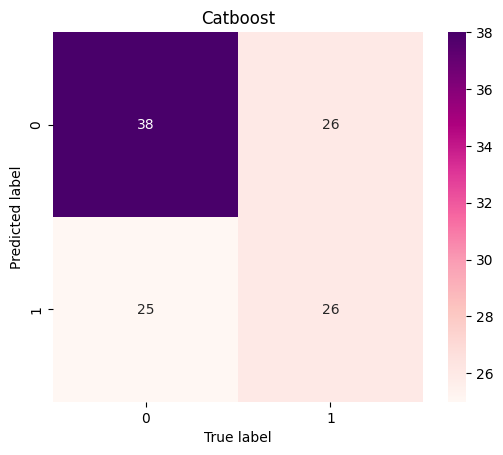

Accuracy:	0.556522
F1-score:	0.504854
Precision:	0.509804
Recall:		0.500000

Classification performance:
              precision    recall  f1-score   support

           0       0.59      0.60      0.60        63
           1       0.51      0.50      0.50        52

    accuracy                           0.56       115
   macro avg       0.55      0.55      0.55       115
weighted avg       0.56      0.56      0.56       115



In [42]:
mat_catboost = confusion_matrix(y, y_pred_catboost)  
sns.heatmap(mat_catboost.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("Catboost")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_catboost))  
print("F1-score:\t%f" % f1_score(y, y_pred_catboost))  
print("Precision:\t%f" % precision_score(y, y_pred_catboost))  
print("Recall:\t\t%f" % recall_score(y, y_pred_catboost))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_catboost))  